# Computing Zonal Stats

## Part 1: Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import rasterio as rio
import rioxarray as rxr
import xarray as xr
import rasterstats

## Part 2: Loading in data

### 2.1 Seattle road edges

In [2]:
seattle_road_path = '/home/jovyan/seattle-micromobility/seattle_road_edges.geojson'
seattle_road_gdf = gpd.read_file(seattle_road_path)

Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field tunnel: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field service: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5


#### Plotting to make sure it looks good:

<Axes: >

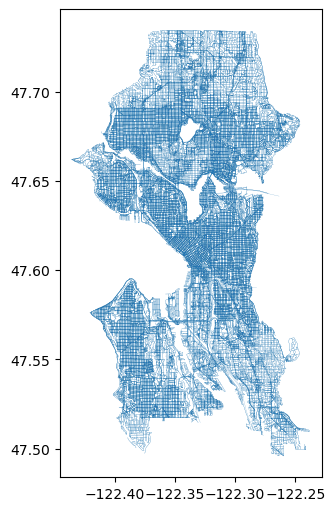

In [18]:
f, ax = plt.subplots(1,1, figsize=(5, 5), layout='constrained')
seattle_road_gdf.plot(ax=ax, linewidth=.1)

### 2.2 Seattle slope raster

In [3]:
seattle_slope_raster ='/home/jovyan/seattle-micromobility/seattle_slope_lowres.tif'

In [48]:
seattle_slope = rxr.open_rasterio(seattle_slope_raster).squeeze()
seattle_slope = seattle_slope.where(seattle_slope != seattle_slope.rio.nodata)

#### Plotting to make sure it looks good:

Text(0.5, 1.0, 'Seattle Slope Map')

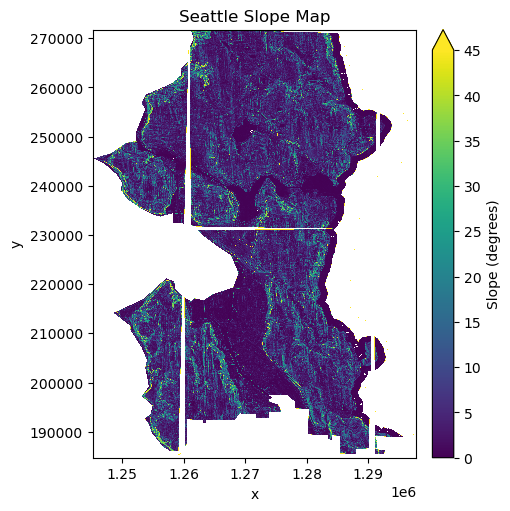

In [81]:
f, ax = plt.subplots(1,1, figsize=(5, 5), layout='constrained')

seattle_slope.plot.imshow(ax=ax,vmin=0, vmax=45, cbar_kwargs={'label':'Slope (degrees)'}, robust=True)
ax.set_title('Seattle Slope Map')

## Part 3: Computing and plotting slope statistics

### Pick which roads to use for stats

In [74]:
#testing on 1 road
roads_sorted_length = seattle_road_gdf.sort_values(by='length', ascending=False)
roads_sorted_length_1 = roads_sorted_length[0:1]

In [75]:
#change crs of the gdf to match the raster
roads_sorted_length_1 = roads_sorted_length_1.to_crs(seattle_slope.rio.crs)

### Create a buffer geometry to use for stats

In [88]:
buffer = roads_sorted_length_1.buffer(100)
road_buffer_gdf = gpd.GeoDataFrame(roads_sorted_length_1.copy(), geometry=buffer)
road_buffer_gdf

,u,v,key,osmid,oneway,ref,reversed,length,junction,est_width,geometry
29156,53198504,5429882617,0,"[ 806287460, 444659036 ]",False,None,"[ false, true ]",4444.396528,None,None,"POLYGON ((1276296.671 201571.763, 1276876.748 ..."


### Plot to check geometry

<Axes: >

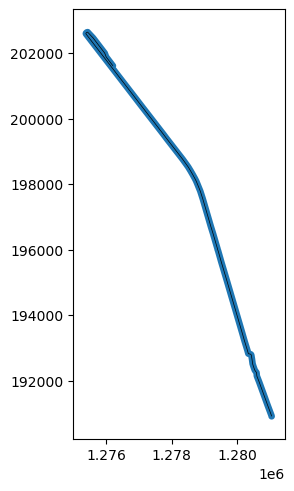

In [89]:
f, ax = plt.subplots(1,1, layout='constrained')
roads_sorted_length_1.plot(ax=ax, color='k', linewidth=.5)
road_buffer_gdf.plot(ax=ax)

### Calculate stats using rasterstats

In [85]:
stats = rasterstats.zonal_stats(road_buffer_gdf.geometry, seattle_slope.values,
                                affine=seattle_slope.rio.transform(),
                                nodata=seattle_slope.rio.nodata,
                                stats=['mean', 'std'])

### Add stats to the gdf

In [86]:
stats_df = pd.DataFrame(stats)
road_buffer_gdf['mean slope'] = stats_df['mean']
road_buffer_gdf['std of slope'] = stats_df['std']

In [87]:
road_buffer_gdf

,u,v,key,osmid,oneway,ref,reversed,length,junction,est_width,geometry,mean slope,std of slope
29156,53198504,5429882617,0,"[ 806287460, 444659036 ]",False,None,"[ false, true ]",4444.396528,None,None,"POLYGON ((1276296.671 201571.763, 1276876.748 ...",NaN,NaN


### Plot